In [275]:
import sys
sys.path.append("../")
import numpy as np
import csv
import os
import pandas as pd
import importlib
import matplotlib.pyplot as plt
import scripts.theodolite_utils as theodo_u
theodo_u = importlib.reload(theodo_u)
import warnings
warnings.filterwarnings('ignore')
from scipy.spatial.transform import Rotation as R_scipy

## Select date of the data to compute

In [218]:
# Path of output
path = "../data/20230725-1/"

## 0. Synchronize RTS Timestamp with GNSS Timestamp

In [314]:
theodo_u = importlib.reload(theodo_u)

df_rts = pd.read_csv(path + "ground_truth/groundtruth_rts_lidar.csv", names=["Timestamp", "X", "Y", "Z", "qx", "qy", "qz", "qw"], delimiter= ' ')
df_gps = pd.read_csv(path + "ground_truth/groundtruth_gps_lidar.csv", delimiter= ',')

df_rts['Timestamp'] = pd.to_datetime(df_rts['Timestamp'], unit='s') # Convert to datetime
df_rts['Timestamp'] -= pd.Timedelta(hours=4) # Subtract 4 hours from the RTS Timestamp column
df_rts['Timestamp'] = df_rts["Timestamp"].values.astype(np.int64) // 10 ** 9 # Convert to Unix Timestamp

# print(df_rts.head())
# print(df_gps.head())


## 1. Compute transformation matrix from RTS frame to GNSS frame : $T_{RTS}^{GNSS}$.

In [315]:
print(len(df_rts['Timestamp']))
print(len(df_gps['Timestamp']))

3109
1183


In [317]:
traj = pd.merge(df_rts[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw']], df_gps[['Timestamp', 'X', 'Y', 'Z', 'qx','qy','qz','qw','PDOP','Sats']], on=['Timestamp'])
X_rts = traj['X_x']
Y_rts = traj['Y_x']
Z_rts = traj['Z_x']
X_gps = traj['X_y']
Y_gps = traj['Y_y']
Z_gps = traj['Z_y']
# print(traj.head())

In [320]:
def get_icp_solution(P, Q):
    mu_P = np.mean(P, axis=1)[:,np.newaxis] #np.newaxis : add a line of 1 for the point list
    mu_Q = np.mean(Q, axis=1)[:,np.newaxis]

    P -= np.full(P.shape, mu_P)
    Q -= np.full(Q.shape, mu_Q)

    H = P @ Q.T

    U, S, V = np.linalg.svd(H, full_matrices=True)

    M = np.eye(4)
    M[3, 3] = np.linalg.det(V @ U.T)
    C = V @ M @ U.T

    r = (mu_Q - C @ mu_P).flatten()
    
    T = np.eye(4)
    T[0:3, 0:3] = C[0:3, 0:3]
    T[0:3, 3] = r[0:3]
    return T, C, r

In [321]:
P = np.array([X_rts, Y_rts, Z_rts,np.ones(len(X_rts))])
Q = np.array([X_gps, Y_gps, Z_gps,np.ones(len(X_gps))])

T, C, r = get_icp_solution(P, Q)
P = np.array([X_rts, Y_rts, Z_rts,np.ones(len(X_rts))])
P_transformed = T @ P
# print(P_transformed)

Rot = R_scipy.from_matrix(C[:3,:3])
Rot = Rot.as_euler('xyz', degrees=True)

print("Rotation angles: ", Rot[0], Rot[1], Rot[2])

X_rts_transformed = P_transformed[0,:]
Y_rts_transformed = P_transformed[1,:]
Z_rts_transformed = P_transformed[2,:]

Rotation angles:  -1.1842797655990032 -0.06172698581361229 -113.64722969550377


In [322]:
# fig, ax  = plt.subplots(figsize=(8, 8))

# ax.scatter(X_rts, Y_rts, color='pink', s=3)
# ax.set_aspect('equal')

In [323]:
# fig, ax  = plt.subplots(figsize=(8, 8))

# ax.scatter(X_gps, Y_gps, color='pink', s=3)
# ax.set_aspect('equal')

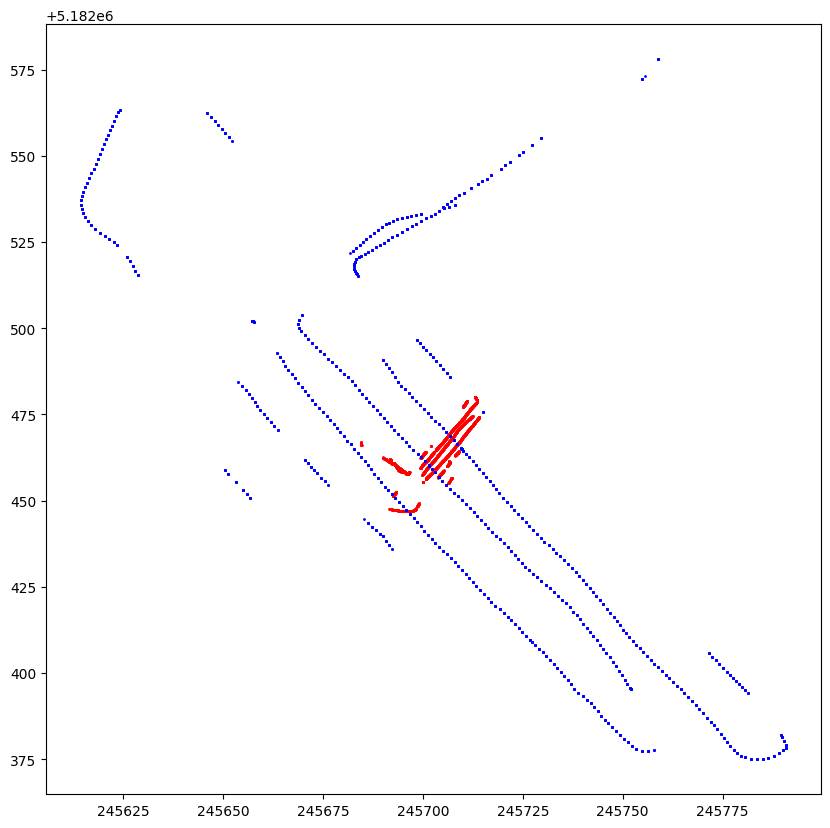

In [324]:
plt.figure(figsize=(10,10))

plt.scatter(X_rts_transformed, Y_rts_transformed, s=1, c='r', label='RTS')
plt.scatter(X_gps, Y_gps, s=1, c='b', label='GPS')
plt.show()

In [231]:
# poses = []
# for i in range(len(traj)) :
#     P = np.array([[X_rts[i]], [Y_rts[i]],[Z_rts[i]],[1]])
#     Q = np.array([[X_gps[i]], [Y_gps[i]], [Z_gps[i]],[1]])
#     T, C, r = get_icp_solution(P, Q)
#     P = np.array([[X_rts[i]], [Y_rts[i]],[Z_rts[i]],[1]]) #fix the P and Q = 0 bug du to the fact that P and Q are modified in get_icp_solution
#     rts_transformed = T @ P
#     poses.append([rts_transformed[0],rts_transformed[1],rts_transformed[2]])
# traj['X'], traj['Y'], traj['Z'] = zip(*poses)
# traj = traj[['X', 'Y', 'Z']]

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 2.45659092e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 5.18250291e+06]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 9.12446720e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 2.45659092e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 5.18250291e+06]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 9.12447002e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 2.45659092e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 5.18250291e+06]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 9.12447067e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 2.45659092e+05]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 5.18250289e+06]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 9.00102197e+01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.000

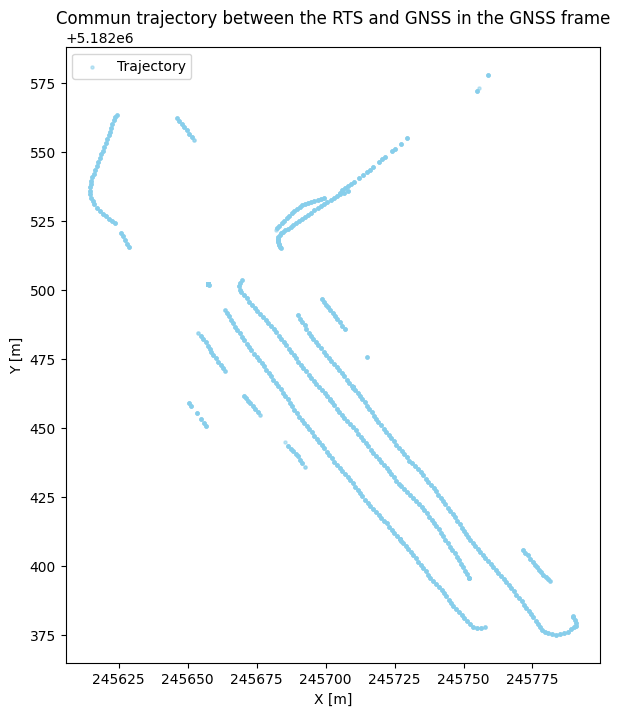

In [224]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(8, 8))

# ax.scatter(traj['X'][1:], traj['Y'][1:], c='skyblue', label='Trajectory', s=5, alpha=0.5)
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Y [m]')
# ax.set_title('Common trajectory between the RTS and GNSS in the GNSS frame')
# ax.legend()
# ax.set_aspect('equal')

# plt.show()

## 2. Find interval with no RTS or GNSS data and complete the map

AttributeError: 'Figure' object has no attribute 'set_aspect'

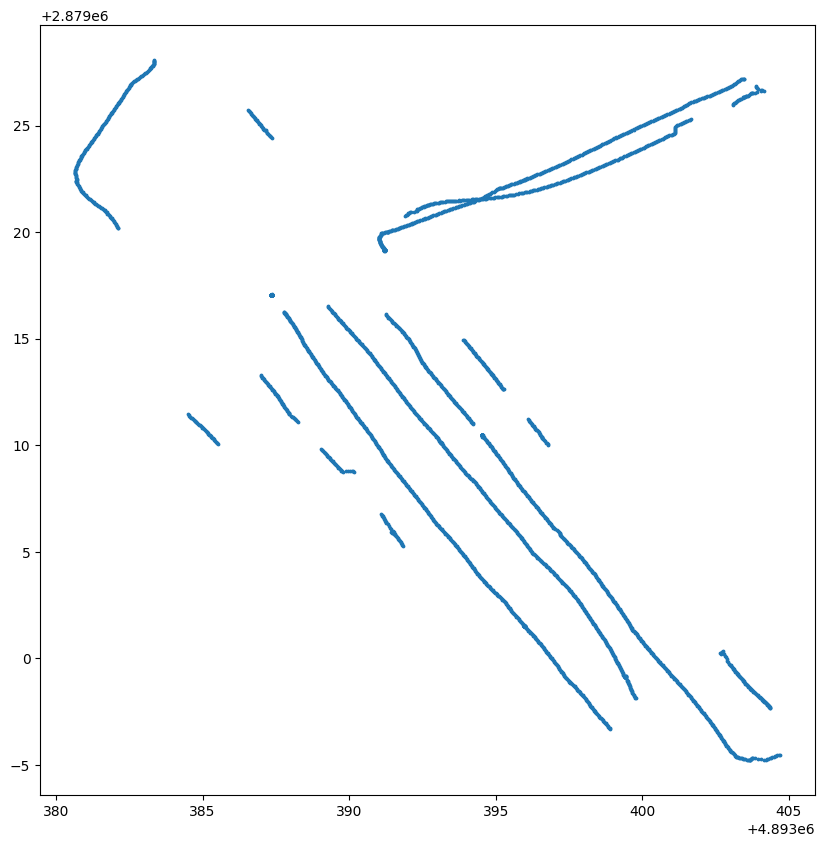

In [313]:
# X_rts = df_rts['X'].values
# Y_rts = df_rts['Y'].values
# Z_rts = df_rts['Z'].values

# for i in range(len(df_rts['X'])) :
#     P = np.array([[X_rts[i]], [Y_rts[i]],[Z_rts[i]],[1]])
#     transformed = T @ P
#     df_rts['X'][i] = transformed[0]
#     df_rts['Y'][i] = transformed[1]
#     df_rts['Z'][i] = transformed[2] 
    

# ax = plt.figure(figsize=(10, 10))
# plt.scatter(df_rts['X'], df_rts['Y'], label='transformed', s=3)
# plt.set_aspect('equal')
# plt.show()

## 3. Final plot with common and not common trajectory

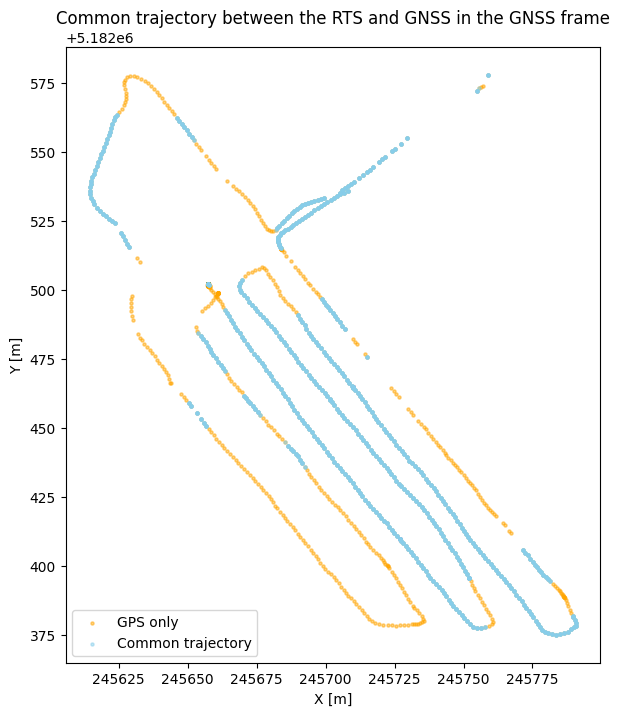

In [230]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.scatter(df_gps['X'], df_gps['Y'], c = 'orange', label='GPS only', s=5, alpha=0.5)
# ax.scatter(traj['X'][1:], traj['Y'][1:], c='skyblue', label='Common trajectory', s=5, alpha=0.5)

# ax.set_xlabel('X [m]')
# ax.set_ylabel('Y [m]')
# ax.set_title('Common trajectory between the RTS and GNSS in the GNSS frame')
# ax.legend()
# ax.set_aspect('equal')

# plt.show()